In [1]:
using Pkg
Pkg.activate("../")

using Revise
using ProbabilisticFSMs

 Activating environment at `~/GithubRepositories/ProbabilisticFSMs/Project.toml`
┌ Info: Precompiling ProbabilisticFSMs [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1260


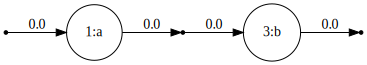

In [2]:
emissions_names = Dict{StateID, AbstractString}(
    1 => "a",
    2 => "b",
    3 => "c",
    4 => "d"
)

fsm = FSM(emissions_names)
s1 = addstate!(fsm, State(1, pdfindex = 1))
s2 = addstate!(fsm, State(2))
s3 = addstate!(fsm, State(3, pdfindex = 2))

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

fsm

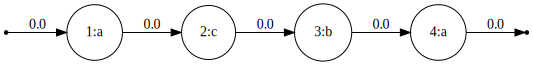

In [3]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissions_names)

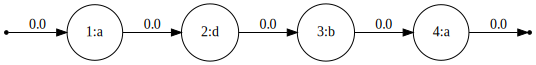

In [4]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissions_names)

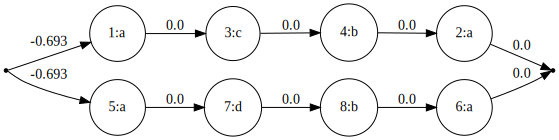

In [5]:
fsm = union(fsm1, fsm2)

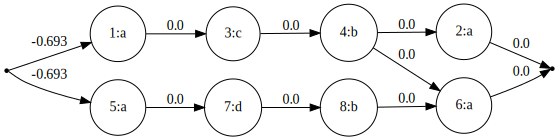

In [7]:
fsm
link!(fsm, fsm.states[4], fsm.states[6], 0.0)
fsm

In [18]:
addstate!(fsm, State(100, 1))

State(100, pdfindex = 1)

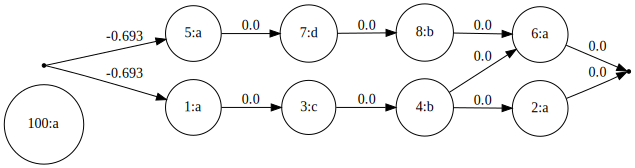

In [22]:
fsm

In [24]:
minimize(fsm) 

MethodError: MethodError: no method matching removestate!(::FSM, ::Int64)
Closest candidates are:
  removestate!(::FSM, !Matched::State) at /home/lucas/GithubRepositories/ProbabilisticFSMs/src/fsm.jl:155

In [21]:
for state in unreachablestates(fsm, forward)
    println(state)
end

100


In [17]:
g = addselfloop(g) |> weightnormalize

UndefVarError: UndefVarError: g not defined

In [217]:
for (sid, state) in g.states
    println("state $(state) : $(state.incoming)")
    println("---")
end

state State(id = initstateid, pdfindex = nothing, initstateid) : Link[]
---
state State(id = 4, pdfindex = 1, a) : Link[Link{Float64}(State(id = initstateid, pdfindex = nothing, initstateid), 0.0), Link{Float64}(State(id = 4, pdfindex = 1, a), -0.6931471805599454)]
---
state State(id = 7, pdfindex = 2, b) : Link[Link{Float64}(State(id = 7, pdfindex = 2, b), -0.6931471805599453), Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453), Link{Float64}(State(id = 6, pdfindex = 4, d), -0.6931471805599453)]
---
state State(id = 2, pdfindex = 3, c) : Link[Link{Float64}(State(id = 4, pdfindex = 1, a), -1.3862943611198906), Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453)]
---
state State(id = finalstateid, pdfindex = nothing, finalstateid) : Link[Link{Float64}(State(id = 5, pdfindex = 1, a), -0.6931471805599453)]
---
state State(id = 5, pdfindex = 1, a) : Link[Link{Float64}(State(id = 7, pdfindex = 2, b), -0.6931471805599453), Link{Float64}(State(id = 5, pdfindex =

In [14]:
D,N = 4,400 # number of distributions times number of frames
v = randn(N, 1) .- 6 
llh = repeat(v', D)

4×400 Array{Float64,2}:
 -7.23752  -5.44423  -5.76237  -4.26329  …  -6.37517  -6.36586  -4.52336
 -7.23752  -5.44423  -5.76237  -4.26329     -6.37517  -6.36586  -4.52336
 -7.23752  -5.44423  -5.76237  -4.26329     -6.37517  -6.36586  -4.52336
 -7.23752  -5.44423  -5.76237  -4.26329     -6.37517  -6.36586  -4.52336

In [25]:
llh = ones(4,5)

4×5 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

In [23]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [15]:
emissionsmap

Dict{String,Int64} with 4 entries:
  "c" => 3
  "b" => 2
  "a" => 1
  "d" => 4

In [47]:
s = g.states[2]
display(s.incoming)
display(s.outgoing)

2-element Array{Link,1}:
 Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453)
 Link{Float64}(State(id = 1, pdfindex = 1, a), -0.6931471805599453)

2-element Array{Link,1}:
 Link{Float64}(State(id = 2, pdfindex = 3, c), -0.6931471805599453)
 Link{Float64}(State(id = 3, pdfindex = 2, b), -0.6931471805599453)

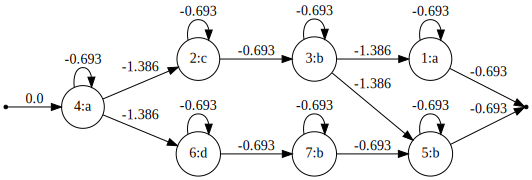

In [26]:
g

In [28]:
α = αrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
α

[n = 1]  	a	4:a = 1.000  
[n = 2]  	a	4:a = 1.307  	2:c = 0.614  	6:d = 0.614  
[n = 3]  	c	4:a = 1.614  	3:b = 0.921  	7:b = 0.921  	2:c = 2.234  	6:d = 2.234  
[n = 4]  	c	1:a = 0.534  	4:a = 1.921  	3:b = 3.089  	7:b = 3.089  	5:b = 2.086  	2:c = 3.635  	6:d = 3.635  
[n = 5]  	b	1:a = 3.759  	4:a = 2.227  	3:b = 4.888  	7:b = 4.888  	5:b = 5.310  	2:c = 4.974  	6:d = 4.974  


In [13]:
β = βrecursion(g, llh; pruning=nopruning) # the lower the more pruning 
β

[n = 1]  	c	1:a = 0.228  	4:a = -1.466  	3:b = 0.558  	5:b = -0.466  	2:c = 0.727  
[n = 2]  	b	1:a = -0.992  	4:a = -1.773  	3:b = 0.469  	5:b = -0.273  	2:c = 0.408  
[n = 3]  	b	4:a = -1.579  	3:b = -0.183  	5:b = -0.579  	2:c = -0.799  
[n = 4]  	b	4:a = -1.386  	3:b = -1.105  	5:b = -0.886  
[n = 5]  	b	4:a = -0.693  	5:b = -0.693  


In [14]:
lnαβ, tll = αβrecursion(g, llh) # the lower the more pruning 
display(tll)
lnαβ

4.798578778287657

Same

[n = 1]  	a	1:a = 1.228  
[n = 2]  	c	1:a = 0.315  	2:c = 0.715  
[n = 3]  	c	3:b = 0.431  	2:c = 1.017  
[n = 4]  	b	4:a = -1.659  	3:b = 2.122  	5:b = -0.659  
[n = 5]  	b	4:a = 1.206  	5:b = 2.206  


State[State(id = 5, pdfindex = 1, a)]
[2.4496921953675406]
-----
State[State(id = 5, pdfindex = 1, a), State(id = 7, pdfindex = 2, b)]
[0.6804271107052051, 2.2143455711413766]
-----
State[State(id = 6, pdfindex = 4, d), State(id = 2, pdfindex = 3, c), State(id = 7, pdfindex = 2, b)]
[1.065389135159319, -2.4302709607893522, -1.709925938893071]
-----
State[State(id = 6, pdfindex = 4, d), State(id = 8, pdfindex = 1, a)]
[1.1020871927699054, -4.924617799721492]
-----
State[State(id = 6, pdfindex = 4, d), State(id = 8, pdfindex = 1, a)]
[0.08948705438494042, -4.1541803992854796]
-----
State[State(id = 6, pdfindex = 4, d), State(id = 8, pdfindex = 1, a)]
[-2.103903668577119, -0.5717629519612493]
-----
State[State(id = 8, pdfindex = 1, a)]
[-0.5717629519612493]
-----


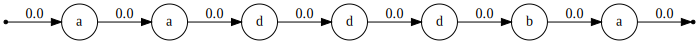

In [18]:
path = viterbi(g, llh)